In [1]:
#TODO test if working for MOP

In [1]:
from evaluation.metrics import redundancy, yNN, d1_distance , d2_distance
from cProfile import label
from datetime import datetime
import pandas as pd
import os
from evaluation.Plots import plot_basic_dataset
from evaluation.metrics import yNN_timeseries
import numpy as np
from pathlib import Path
import platform
import sklearn
import torch
from models.CNN_TSNet import UCRDataset, train
from models.ResNet import ResNetBaseline, fit, get_all_preds
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import numpy as np
from TSEvo.CounterfactualExplanation import Explanation
from evaluation import WachterEtAl, Wachter_CF
import pickle
from evaluation.Plots import plot_CF, plot_CF_Original, plot_CF_Original_Closest
from tslearn.datasets import UCR_UEA_datasets
import warnings
from evaluation.Instance_BasedCF_NativeGuide import NativeGuidCF
from deap import creator, base, algorithms, tools
from deap.benchmarks.tools import hypervolume, diversity, convergence
from tslearn.datasets import UCR_UEA_datasets
# TODO Pay Respect to shape ( Multivariate)
# TODO Ates
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
creator.create("FitnessMin", base.Fitness, weights=(-1.0, -1.0, -1.0, -1.0))
creator.create("Individual", list, fitness=creator.FitnessMin,window=0)

run_on =['ECG5000']
draw_plot=False
os_type= platform.system()
os.environ["CUDA_VISIBLE_DEVICES"]=""
mutation_type=['mutate_both']

for dataset in run_on: 
    if not os.path.isdir(f'./Results/Benchmarking/{dataset}'):
        os.mkdir(f'./Results/Benchmarking/{dataset}')
        
        if dataset in os.listdir('./Results/'):
            pass
        else:
            os.mkdir(f'./Results/{dataset}')
    X_train,train_y,X_test,test_y=UCR_UEA_datasets().load_dataset(dataset)
    train_x=X_train.reshape(-1,X_train.shape[-1],X_train.shape[-2])
    test_x=X_test.reshape(-1,X_train.shape[-1],X_train.shape[-2]) 
    enc1=pickle.load(open(f'./models/{dataset}/OneHotEncoder.pkl','rb'))
    test_y=enc1.transform(test_y.reshape(-1,1))
    n_classes = test_y.shape[1]
    if len(train_x.shape)==2:
        train_x=train_x.reshape(-1,train_x.shape[-2],train_x.shape[-1])
        test_x=test_x.reshape(-1,train_x.shape[-2],train_x.shape[-1])
    '''Load Model'''
    model = ResNetBaseline(in_channels=train_x.shape[-2], num_pred_classes=n_classes)
    model.load_state_dict(torch.load(f'./models/{dataset}/ResNet'))
    model.eval()
    
    y_pred= model(torch.from_numpy(test_x).float()).detach().numpy()
    test_y=y_pred
    '''Explanation Method'''
    from evaluation.COMTE import AtesCF
    from evaluation.Nun_CF import NativeGuideCF
    from evaluation.Wachter_CF import Wachter
    '''Initialize Methods'''
    nguide_cf=NativeGuideCF(model,np.array(train_x).shape, (test_x,test_y))
    ates= AtesCF(model, (test_x,test_y))
  

    '''Calculate'''
    ynn=[]
    ynn_timeseries=[]
    red=[]
    sal_01=[]
    sal_02=[]
    not_valid=0
    wachter_cf=[]
    ynn_wachter=[]
    ynn_timeseries_wachter=[]
    red_wachter=[]
    sal_01_wachter=[]
    sal_02_wachter=[]
    not_valid_wachter=0
    ynn_cfg=[]
    ynn_timeseries_cfg=[]
    red_cfg=[]
    sal_01_cfg=[]
    sal_02_cfg=[]
    cfg_cf=[]
    not_valid_cfg=0
    ynn_ib=[]
    ynn_timeseries_ib=[]
    red_ib=[]
    sal_01_ib=[]
    sal_02_ib=[]
    ib_cf=[]
    not_valid_ib=0
    max_iteration=len(test_y)
    #TODO add time Measure
    for i, item in enumerate(test_x):
        print('Image Number ',{i})
        observation_01=item
        label_01=np.array([test_y[i]])#test_y[0]
        if os.path.exists( f'./Results/mutate_both/{dataset}/Counterfactuals_{i}.pkl'):
            pop=pickle.load(open( f'./Results/mutate_both/{dataset}/Counterfactuals_{i}.pkl', "rb" ))
        else:
            break
        input_ = torch.from_numpy(np.array(item).reshape(1,1,-1)).float()
        output = torch.nn.functional.softmax(model(input_)).detach().numpy()
        y_target =np.argmax(output,axis=1)[0] #output.argmax()
        print(y_target)
        mlmodel = model 
        counterfactuals = pop
        original = observation_01
        #print(y_target)
        #print(counterfactuals[0].output) 
        if y_target == np.argmax(counterfactuals[0].output):
            not_valid=not_valid+1
       
    
        # Wachter et al . 
        #print(item.shape)
        #print(observation_01.shape)
        item = item.reshape(1,item.shape[-2],item.shape[-1])
        import time
        start_time = time.time()
        #     not_valid_wachter=not_valid_wachter+1
        item = item.reshape(1,item.shape[-2],item.shape[-1])
        cfg_counterfactual,label_cfg=nguide_cf.explain(item,  y_target,method='dtw_bary_center')#(mlmodel, item, y_target).reshape(np.array(pop).shape[0],np.array(pop).shape[1],np.array(pop).shape[2])
        cfg_cf.append(cfg_counterfactual)
        if not cfg_counterfactual is None:
            #print(cfg_counterfactual.shape)
            ynn_cfg.append(yNN(cfg_counterfactual, mlmodel,train_x,5,labels=np.array([label_cfg]))[0][0])
            ynn_timeseries_cfg.append(yNN_timeseries(cfg_counterfactual, mlmodel,train_x,5,labels=np.array([label_cfg]))[0][0])
            red_cfg.append(redundancy(original, cfg_counterfactual, mlmodel,labels=np.array([label_cfg]))[0])
            sal_01_cfg.append(d1_distance(observation_01,np.array(cfg_counterfactual)))
            sal_02_cfg.append(d2_distance(observation_01,np.array(cfg_counterfactual)))
            print(label_cfg)
            print(np.argmax(label_01,axis=1))
            if label_cfg == np.argmax(label_01,axis=1)[0]:
                not_valid_cfg=not_valid_cfg+1

        else: 
            print('GradCam not a valid CF!')
            not_valid_cfg=not_valid_cfg+1
        i+=1
        if i ==19:
            break

Image Number  {0}
0
Target 1
query [[4.1785654e-01 5.8206099e-01 1.3931762e-08 8.2048369e-05 3.9626650e-07]]
1.1427172e-05
1
[0]
Image Number  {1}
0
Target 2
query [[2.3153771e-03 1.6225578e-02 1.0969474e-07 9.8145890e-01 1.2583838e-10]]
2.6823452e-07
2
[0]
Image Number  {2}
0
Target 2
query [[2.4777619e-05 9.6368200e-01 1.6112863e-11 3.6293201e-02 2.3813282e-10]]
4.9717596e-06
2
[0]
Image Number  {3}
0
Target 2
query [[8.5511738e-03 9.2991081e-04 3.8052651e-05 9.9048084e-01 7.6315365e-13]]
1.4906935e-05
2
[0]
Image Number  {4}
0
Target 3
query [[8.5511738e-03 9.2991081e-04 3.8052651e-05 9.9048084e-01 7.6315365e-13]]
0.04935598
3
[0]
Image Number  {5}
0
Target 3
query [[2.7546739e-06 2.9548043e-01 1.9013595e-07 7.0451665e-01 1.9895869e-14]]
0.13081016
3
[0]
Image Number  {6}
0
Target 4
query [[2.9477786e-02 1.7131881e-06 9.6977544e-01 4.7169256e-04 2.7336596e-04]]
0.007700951
4
[0]
Image Number  {7}
0
Target 2
query [[2.3153771e-03 1.6225578e-02 1.0969474e-07 9.8145890e-01 1.2583838e-1

In [2]:
ynn_timeseries_cfg

[0.8,
 1.0,
 1.0,
 1.0,
 0.8,
 0.8,
 0.8,
 1.0,
 0.8,
 0.8,
 1.0,
 1.0,
 1.0,
 0.8,
 1.0,
 0.8,
 1.0]

In [4]:
sal_02_cfg

[0.5701173317543633,
 1.5404796552633933,
 1.052611597557521,
 377186485101.4962,
 0.7731305507770719,
 0.33807422440614376,
 0.2466882231221098,
 290705907856.20825,
 0.5003578722619498,
 0.27087293486599356,
 117565994299.06354,
 1.6652318068169385,
 3.0983444256787585,
 0.5211766576997672,
 97979469498.90263,
 2.1074569269423082,
 1.116839285474885]

In [9]:
np.sum(np.abs(test_x[3] -  cfg_cf[3]))

52806107914209.47

In [15]:
np.max(cfg_cf[3])

1.8147850881624383

In [16]:
np.min(cfg_cf[3])

-52806107914168.78

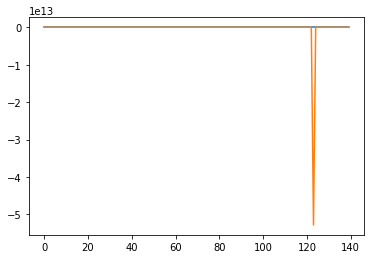

In [13]:
plt.plot(test_x[3].reshape(-1,1))
plt.plot(np.array(cfg_cf[3].reshape(-1,1)))